# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
#import tensorflow as tf
#if tf.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#else:
#    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [2]:
#def download_file(url, file_path):
#    import requests
#    r = requests.get(url)
#    with open(file_path, 'wb') as f:
#        f.write(r.content)

#def load_dataset(file_path, fraction=1.0):
#    with open(file_path, 'r', encoding='utf-8') as f:
#        raw_text = f.read()
#    return raw_text[:int(fraction * len(raw_text))]

#dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

#download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
#text = load_dataset(dataset, fraction=0.1)


# Load the dataset
def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Path to the dataset
dataset_path = 'downloaded_books/shakespeare.txt'

# Load the dataset with a fraction parameter
text = load_dataset(dataset_path, fraction=0.1)


# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
# Print the first 1000 characters
print("First 1000 characters of the dataset:\n")
print(text[:1000])

# Report the dataset's size
dataset_size = len(text)
print(f"\nDataset size: {dataset_size} characters")

# Report the number of unique characters in the dataset
unique_chars = set(text)
num_unique_chars = len(unique_chars)
print(f"Number of unique characters: {num_unique_chars}")

First 1000 characters of the dataset:

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For thi

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

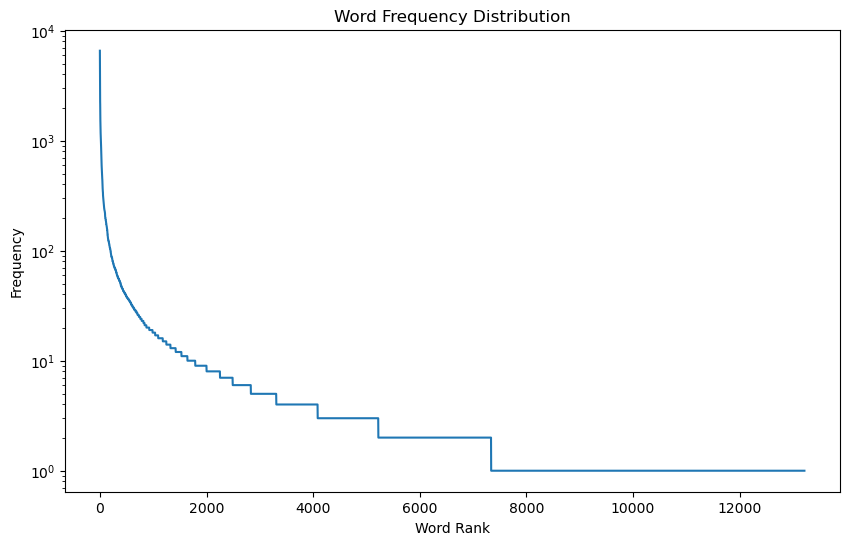

Recommended vocabulary size: 7338
Most common words and their counts:
the: 6571
and: 4663
of: 3815
to: 3687
a: 2686
in: 2258
i: 2130
that: 1693
you: 1692
he: 1538
his: 1419
is: 1351
with: 1282
it: 1266
for: 1174
my: 1142
was: 1119
not: 1114
this: 1083
”: 1080


In [4]:
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Convert text to lowercase
text = text.lower()

# Initialize the tokenizer without setting the num_words parameter yet
OOV_TOKEN = '<OOV>'
tokenizer = Tokenizer(oov_token=OOV_TOKEN)

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])

# Get the word index and word counts
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

# Sort the words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plot the word frequency distribution
word_frequencies = [count for word, count in sorted_words]
plt.figure(figsize=(10, 6))
plt.plot(word_frequencies)
plt.yscale('log')  # Log scale for better visualization of the long tail
plt.title('Word Frequency Distribution')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()

# Determine the vocabulary size
REC_VOCAB_SIZE = sum([1 for count in word_frequencies if count > 1])
print(f"Recommended vocabulary size: {REC_VOCAB_SIZE}")

VOCAB_SIZE=13218+1

# Print some of the most common words and their counts
print("Most common words and their counts:")
for word, count in sorted_words[:20]:
    print(f"{word}: {count}")

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [5]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [6]:
import numpy as np

# Set an appropriate sequence length
SEQ_LENGTH = 40  # Adjust this value as needed

# Convert text to sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []

for i in range(SEQ_LENGTH, len(sequences)):
    # Create sequences of length SEQ_LENGTH
    X.append(sequences[i-SEQ_LENGTH:i])
    # The target token is the word that follows the sequence
    y.append(sequences[i])

# Convert X and y to numpy arrays for training
X = np.array(X)
y = np.array(y)

# Print some information about the generated sequences
print(f"Number of training sequences: {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"First training sequence (input): {X[0]}")
print(f"Target token for the first sequence: {y[0]}")

Number of training sequences: 156631
Shape of X: (156631, 40)
Shape of y: (156631,)
First training sequence (input): [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2]
Target token for the first sequence: 216


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [7]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2]
Target: 216
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the'] -> terms


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (125304, 40)
y_train shape: (125304, 13219)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

EMBEDDING_DIM = 100  # Dimension of the embedding vectors
RNN_UNITS = 128     # Number of units in the RNN layer

model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH))

# Add LSTM layer (or any other RNN layer)
model.add(LSTM(RNN_UNITS))

# Add dense layer with softmax activation
model.add(Dense(VOCAB_SIZE, activation='softmax'))

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           1321900   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 13219)             1705251   
                                                                 
Total params: 3,144,399
Trainable params: 3,144,399
Non-trainable params: 0
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

## Answer 2.2 
**Loss Function:** categorical_crossentropy.  per live lessons this loss function is ideal for multi-class classification tasks where the target is one-hot encoded. It quantifies the difference between the predicted probabilities and the actual one-hot encoded target, guiding the model to improve its predictions.

**Optimizer:** Adam. Adam adjusts learning rates based on training data, helping the model to converge faster and handle complex training dynamics

In [12]:
from keras.optimizers import Adam
# Set a learning rate
learning_rate = 0.001 

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [13]:
history = model.fit(
    X_train,         # Training features
    y_train,         # Training targets
    epochs=5,        # Number of epochs
    batch_size=128,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=2        # Verbosity mode 
)

Epoch 1/5
979/979 - 109s - loss: 7.1918 - accuracy: 0.0478 - val_loss: 6.9477 - val_accuracy: 0.0615 - 109s/epoch - 111ms/step
Epoch 2/5
979/979 - 105s - loss: 6.6290 - accuracy: 0.0731 - val_loss: 6.6494 - val_accuracy: 0.0791 - 105s/epoch - 107ms/step
Epoch 3/5
979/979 - 103s - loss: 6.2185 - accuracy: 0.0973 - val_loss: 6.4239 - val_accuracy: 0.1011 - 103s/epoch - 106ms/step
Epoch 4/5
979/979 - 109s - loss: 5.8587 - accuracy: 0.1177 - val_loss: 6.2935 - val_accuracy: 0.1113 - 109s/epoch - 112ms/step
Epoch 5/5
979/979 - 112s - loss: 5.5698 - accuracy: 0.1321 - val_loss: 6.2412 - val_accuracy: 0.1214 - 112s/epoch - 115ms/step


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

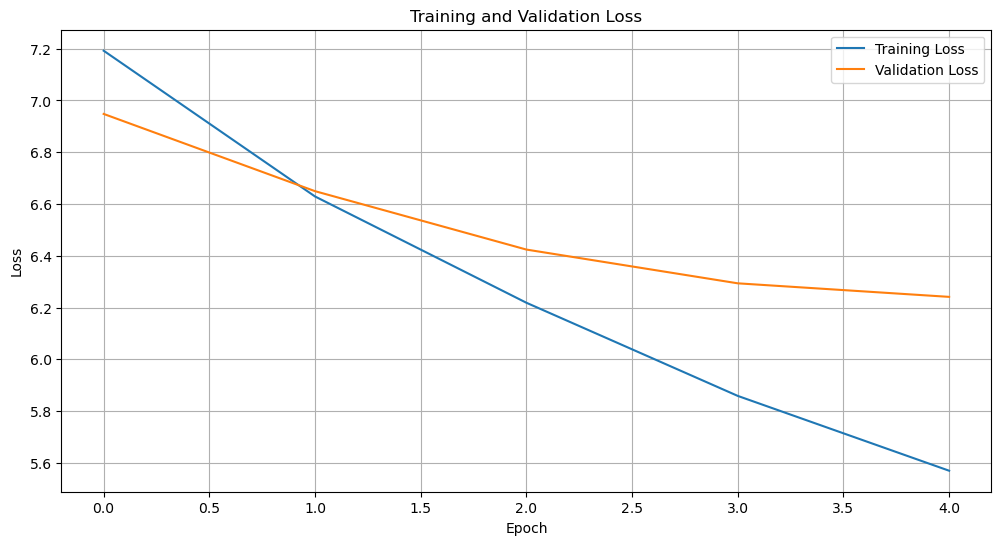

In [14]:
import matplotlib.pyplot as plt

# Retrieve the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50):
    """
    Generate new text using the trained model.
    
    :param model: The trained RNN model.
    :param tokenizer: The tokenizer used to pre-process the text data.
    :param seed_text: The seed text the model will use to generate new text.
    :param max_sequence_len: The maximum length of the sequence used to generate new text.
    :param num_words_to_generate: Number of words to generate.
    :return: The generated text.
    """
    # Convert seed text to sequence
    sequence = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Ensure the sequence is the correct length
    sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding='pre')

    generated_words = []

    for _ in range(num_words_to_generate):
        # Get the predicted word
        predicted_word_id = get_predicted_word(model, sequence)
        
        # Convert the predicted word ID to a word
        predicted_word = tokenizer.index_word.get(predicted_word_id, '')
        
        # Stop if the predicted word is empty
        if not predicted_word:
            break
        
        # Add the word to the generated words list
        generated_words.append(predicted_word)
        
        # Update the sequence with the predicted word
        sequence = np.append(sequence[:, 1:], [[predicted_word_id]], axis=1)

    # Combine the generated words into a single string
    return ' '.join(generated_words)


In [16]:
# Test the text generation function
generated_text=generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)
print(generated_text)

april became capell 161 quotation for fury so 213 sometimes utf mightst rivall 235 f of kind ’twere sending the change fortune of everything and here does despite there are at the earlier act of shakespeare stint efforts of cæsar also shakespeare “tell to him if his life giving we


It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

## Answer 4: 
I chose to use  pre-trained embeddings. CODE BELOW

In [17]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip glove.6B.zip

#import requests
#import zipfile
#import io
#import os

# Define the URL and the target directory
#url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
#target_dir = '.'  # Current directory (same as the Jupyter notebook)

# Download the file
#response = requests.get(url)
#with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#    z.extractall(target_dir)  # Extract to the current directory

#print("Download and extraction complete.")

In [18]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [19]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [20]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam

model2 = Sequential([
    # Add the pre-defined and pre-trained embedding layer
    embedding_layer,
    LSTM(RNN_UNITS),
    Dense(VOCAB_SIZE, activation='softmax')
])

# Set the embedding layer's trainable attribute to False to not fine-tune the embeddings - you can try to change this
model2.layers[0].trainable = False

# Compile the model
# Set a learning rate
learning_rate = 0.001 

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model2.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Print the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           1321900   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 13219)             1705251   
                                                                 
Total params: 3,144,399
Trainable params: 1,822,499
Non-trainable params: 1,321,900
_________________________________________________________________


In [25]:
history = model2.fit(
    X_train,         # Training features
    y_train,         # Training targets
    epochs=5,        # Number of epochs
    batch_size=128,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=2        # Verbosity mode 
)

Epoch 1/5
979/979 - 91s - loss: 7.1163 - accuracy: 0.0507 - val_loss: 6.7822 - val_accuracy: 0.0662 - 91s/epoch - 93ms/step
Epoch 2/5
979/979 - 107s - loss: 6.4219 - accuracy: 0.0824 - val_loss: 6.4074 - val_accuracy: 0.0900 - 107s/epoch - 109ms/step
Epoch 3/5
979/979 - 98s - loss: 6.0116 - accuracy: 0.1006 - val_loss: 6.2307 - val_accuracy: 0.1052 - 98s/epoch - 100ms/step
Epoch 4/5
979/979 - 97s - loss: 5.7053 - accuracy: 0.1124 - val_loss: 6.1262 - val_accuracy: 0.1145 - 97s/epoch - 99ms/step
Epoch 5/5
979/979 - 97s - loss: 5.4393 - accuracy: 0.1228 - val_loss: 6.0677 - val_accuracy: 0.1197 - 97s/epoch - 99ms/step


In [26]:
# Test the text generation function on model2
generated_text=generate_text(model2, tokenizer, 'hamlet', SEQ_LENGTH)
print(generated_text)

hanmer enter court by syracuse 145 chief ff reapers to try om ff walker once heavily home ant conj conj note mer 33 o 101 educational brack’d messenger sedge nostrils we note warburton to be “let 131 for certain hate rowe ff sir ff 61 discovers mind 91 till f1


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.